# STEP 1: IMPORT ALL NECESSARY LIBRARIES

In [ ]:
# Install required libraries
!pip install scikit-image -q

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from tqdm import tqdm

# Scikit-learn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder


# For HOG features
from skimage.feature import hog
from skimage import exposure



from sklearn.metrics import  classification_report ,  confusion_matrix,  accuracy_score,   precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # we use for normalization

from skimage. io import imread  # to deal with images

from skimage.transform import resize

import pickle # Save trained models

# ==============================================================================
# WHY ARE THESE LIBRARIES IMPORTANT?
# ==============================================================================
# NumPy    → Fast mathematical operations on arrays
# OS       → Read/write files and navigate folders
# Sklearn  → Machine learning algorithms and metrics
# Skimage  → Image processing (resize, normalize)
# Matplotlib → Visualize results
# Pickle   → Save trained models

In [ ]:
import zipfile



with zipfile.ZipFile("ZIP_cropped_objectsV3.zip", 'r') as zip_ref:
    zip_ref.extractall('cropped_dataset')





In [ ]:
DATASET_PATH = 'cropped_dataset/cropped_objectsV3'


TARGET_SIZE = (64, 64)

# OUTPUT_DIR = 'svm_baseline'


print("✓ Configuration loaded!")
print(f"  Dataset path: {DATASET_PATH}")

# OUTPUT_DIR = 'svm_baseline'

# Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

#print(f"  Output directory: {OUTPUT_DIR}")

✓ Configuration loaded!
  Dataset path: cropped_dataset/cropped_objectsV3


In [ ]:
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm

# ✅ Set the correct path to the train split
train_PATH = Path("cropped_dataset/train")
TARGET_SIZE = (64, 64)

train_images = []
train_labels = []
class_names = []

# ✅ Get all class folders inside train/
if not train_PATH.exists():
    raise FileNotFoundError(f" Dataset path not found: {DATASET_PATH}")

class_folders = sorted([d for d in train_PATH.iterdir() if d.is_dir()])

print(f"\n Loading TRAINING data...")
print(f"Found {len(class_folders)} classes: {[f.name for f in class_folders]}")

for class_folder in class_folders:
    class_name = class_folder.name
    class_names.append(class_name)

    image_files = list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png"))

    print(f"  {class_name}: {len(image_files)} images")

    for img_path in tqdm(image_files, desc=f"Loading {class_name}", leave=False):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(class_name)

X_train_img = np.array(train_images)
y_train = np.array(train_labels)
class_names = sorted(list(set(class_names)))

print(f"\n Loaded {len(X_train_img)} training images")
print(f" Classes: {class_names}")
print(f" Image shape: {X_train_img[0].shape}")


 Loading TRAINING data...
Found 7 classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  bicycles: 46 images


  buses: 88 images


  crosswalks: 157 images


  fire hydrants: 60 images


  motorcycles: 158 images


  traffic lights: 459 images


  vehicles: 763 images



 Loaded 1731 training images
 Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
 Image shape: (64, 64)


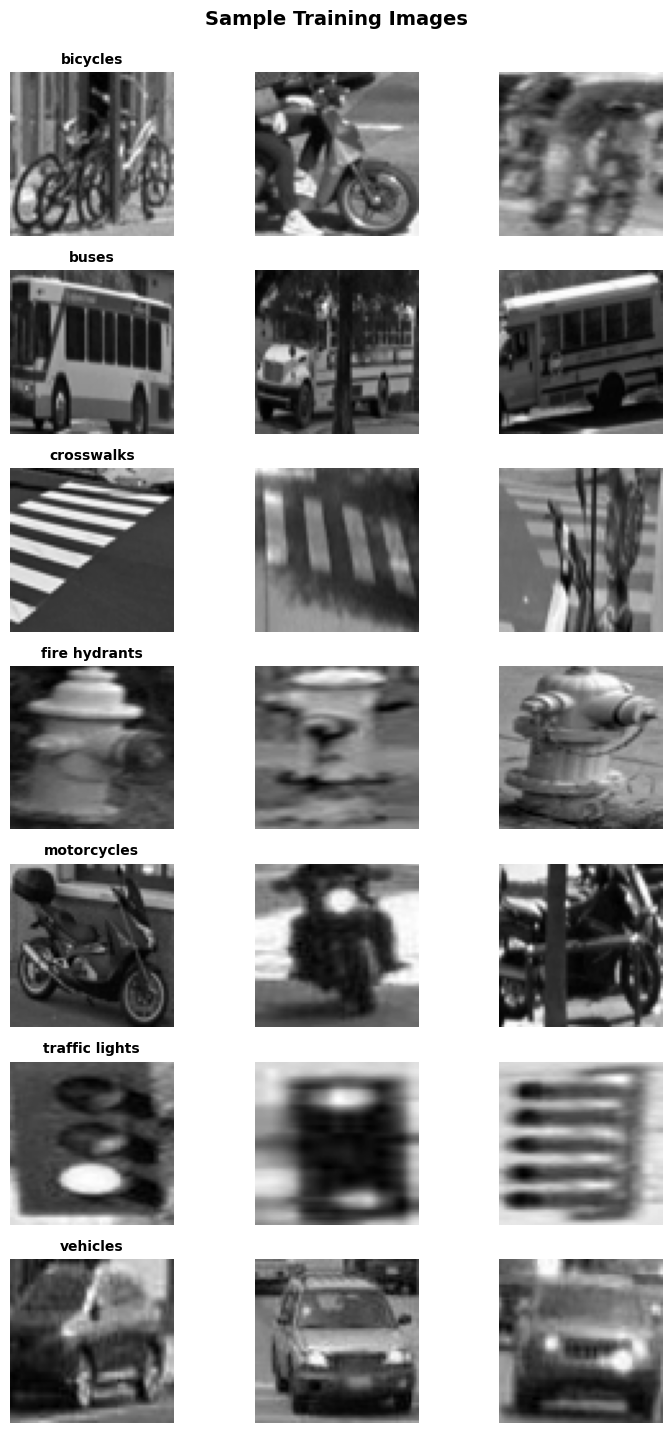

In [ ]:
# Visualize 3 samples from each class
n_classes = len(class_names)
samples_per_class = 3

fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(8, n_classes*2))

for i, class_name in enumerate(class_names):
    # Get indices for this class
    class_indices = np.where(y_train == class_name)[0]

    # Sample random images
    sample_indices = np.random.choice(class_indices,
                                     min(samples_per_class, len(class_indices)),
                                     replace=False)

    for j, idx in enumerate(sample_indices):
        if n_classes == 1:
            axes[j].imshow(X_train_img[idx], cmap='gray')
            axes[j].axis('off')
        else:
            axes[i, j].imshow(X_train_img[idx], cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{class_name}", fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle("Sample Training Images", y=1.02, fontsize=14, fontweight='bold')
plt.show()


📊 Training Class Distribution:
         Class  Count
      vehicles    763
traffic lights    459
   motorcycles    158
    crosswalks    157
         buses     88
 fire hydrants     60
      bicycles     46

⚖️  Imbalance Ratio: 16.59
⚠️  Dataset is IMBALANCED - we'll use class_weight='balanced' in SVM


/tmp/ipython-input-3040220702.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')


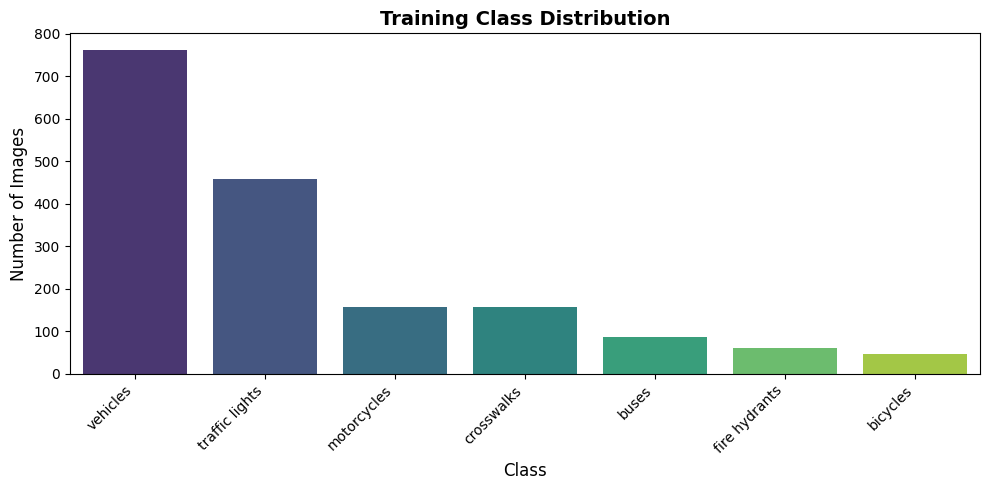

In [ ]:
# Count images per class
unique, counts = np.unique(y_train, return_counts=True)

# Create DataFrame
df_dist = pd.DataFrame({'Class': unique, 'Count': counts})
df_dist = df_dist.sort_values('Count', ascending=False)

print(f"\n📊 Training Class Distribution:")
print(df_dist.to_string(index=False))

# Check balance
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count

print(f"\n⚖️  Imbalance Ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️  Dataset is IMBALANCED - we'll use class_weight='balanced' in SVM")
else:
    print("✅ Dataset is relatively BALANCED")

# Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(data=df_dist, x='Class', y='Count', palette='viridis')
plt.title('Training Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#  what HOG features look like

# What Are HOG Features?
HOG stands for Histogram of Oriented Gradients. It’s a way to **describe the shape and edges** in an image by looking at how **the brightness changes**.
 How It Works:
- Divide the image into small cells (e.g., 8×8 pixels).
- Compute gradients: For each pixel, measure how brightness changes in horizontal and vertical directions.
- Bin the gradient directions: Count how many gradients point in each direction (like a compass).
- Normalize across blocks: Combine neighboring cells to reduce noise and lighting effects.
- Flatten into a feature vector: You get a long list of numbers (e.g., 1764 values) that describe the image’s edge patterns.


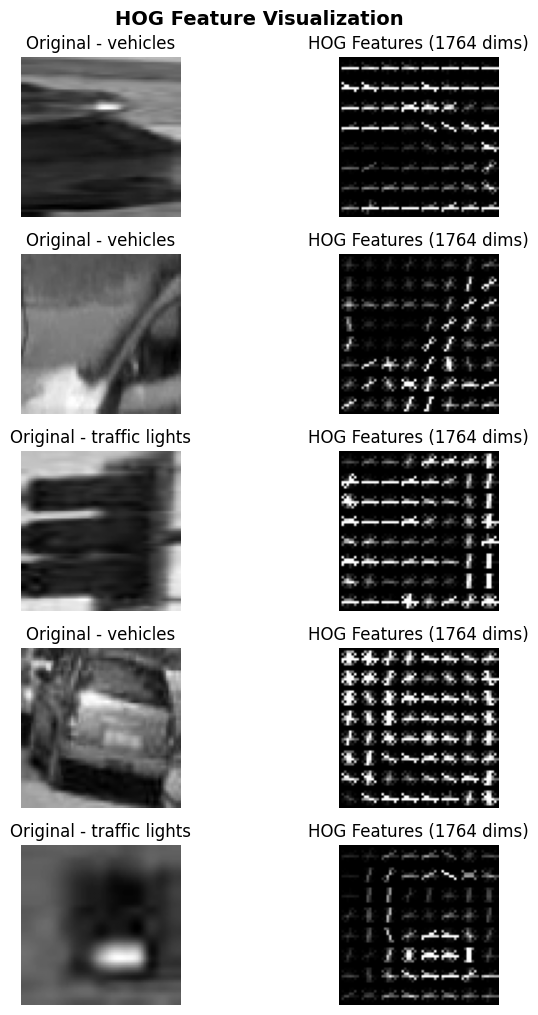


💡 Each 64×64 image → 1764 HOG features
   (These capture edge directions and shapes)


In [ ]:
# Let's see what HOG features look like
n_samples = 5
fig, axes = plt.subplots(n_samples, 2, figsize=(8, n_samples*2))

# Sample random images
sample_indices = np.random.choice(len(X_train_img), n_samples, replace=False)

for i, idx in enumerate(sample_indices):
    img = X_train_img[idx]
    label = y_train[idx]

    # Extract HOG with visualization
    features, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True)

    # Rescale for better visualization
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # Original
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(f"Original - {label}")
    axes[i, 0].axis('off')

    # HOG
    axes[i, 1].imshow(hog_image, cmap='gray')
    axes[i, 1].set_title(f"HOG Features ({len(features)} dims)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.suptitle("HOG Feature Visualization", y=1.01, fontsize=14, fontweight='bold')
plt.show()

print(f"\n💡 Each 64×64 image → {len(features)} HOG features")

print("   (These capture edge directions and shapes)")

# What You See in the Images
- Original grayscale image: Just raw pixel values — blurry, hard to interpret.
- HOG visualization: Shows arrows or lines where edges are strongest — outlines of buses, wheels, crosswalks,


## 🤖 Why SVM Loves HOG Features
# ✅ SVM Strengths:
- SVM is great at finding boundaries between classes.
- It works best when the input features are consistent, high-dimensional, and edge-sensitive.
# ❌ Raw Pixels Are Weak Because:
- They’re sensitive to lighting, position, and background.
- Two images of the same object might look very different in pixel values.
# ✅ HOG Features Are Better Because:
- They focus on shape and structure, not color or texture.
- They’re invariant to small shifts, lighting changes, and noise.
- They give SVM a stable, descriptive input that separates classes more clearly.


In [ ]:
print(f"\n🔬 Extracting HOG features for {len(X_train_img)} training images...")

X_train_hog = []

for img in tqdm(X_train_img, desc="Extracting HOG"):
    features = hog(img,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   visualize=False,
                   feature_vector=True)
    X_train_hog.append(features)

X_train_hog = np.array(X_train_hog)

print(f"✅ HOG features extracted!")
print(f"   Shape: {X_train_hog.shape}")
print(f"   Each image → {X_train_hog.shape[1]} features")


🔬 Extracting HOG features for 1731 training images...


Extracting HOG: 100%|██████████| 1731/1731 [00:04<00:00, 416.87it/s]

✅ HOG features extracted!
   Shape: (1731, 1764)
   Each image → 1764 features


# now we do the same with the valid and test sets
we exctract the HOG features

In [ ]:
valid_PATH = Path("cropped_dataset/valid")
valid_images = []
valid_labels = []

if not valid_PATH.exists():
    raise FileNotFoundError(f"❌ Dataset path not found: {valid_PATH}")

valid_class_folders = sorted([d for d in valid_PATH.iterdir() if d.is_dir()])

print(f"\n Loading VALIDATION data...")
print(f"Found {len(valid_class_folders)} classes: {[f.name for f in valid_class_folders]}")

for class_folder in valid_class_folders:
    class_name = class_folder.name

    image_files = list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png"))
    print(f"  {class_name}: {len(image_files)} images")

    for img_path in tqdm(image_files, desc=f"Loading {class_name}", leave=False):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, TARGET_SIZE)
        valid_images.append(img)
        valid_labels.append(class_name)

X_valid_img = np.array(valid_images)
y_valid = np.array(valid_labels)


print(f"\n Loaded {len(X_valid_img)} training images")
print(f" Classes: {class_names}")
print(f" Image shape: {X_valid_img[0].shape}")


 Loading VALIDATION data...
Found 7 classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  bicycles: 14 images


  buses: 11 images


  crosswalks: 46 images


  fire hydrants: 11 images


  motorcycles: 52 images


  traffic lights: 364 images


  vehicles: 300 images



 Loaded 798 training images
 Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
 Image shape: (64, 64)


In [ ]:
print(f"\n🔬 Extracting HOG features for validation...")

X_valid_hog = []

for img in tqdm(X_valid_img, desc="Extracting HOG"):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
    X_valid_hog.append(features)

X_valid_hog = np.array(X_valid_hog)
print(f"✅ Validation HOG shape: {X_valid_hog.shape}")


🔬 Extracting HOG features for validation...


Extracting HOG: 100%|██████████| 798/798 [00:01<00:00, 532.14it/s]

✅ Validation HOG shape: (798, 1764)


In [ ]:
test_PATH = Path("cropped_dataset/test")
test_images = []
test_labels = []

if not test_PATH.exists():
    raise FileNotFoundError(f"❌ Dataset path not found: {test_PATH}")

test_class_folders = sorted([d for d in test_PATH.iterdir() if d.is_dir()])

print(f"\n📂 Loading TEST data...")
print(f"Found {len(test_class_folders)} classes: {[f.name for f in test_class_folders]}")

for class_folder in test_class_folders:
    class_name = class_folder.name

    image_files = list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png"))
    print(f"  {class_name}: {len(image_files)} images")

    for img_path in tqdm(image_files, desc=f"Loading {class_name}", leave=False):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        test_labels.append(class_name)

X_test_img = np.array(test_images)
y_test = np.array(test_labels)

print(f"\n Loaded {len(X_test_img)} training images")
print(f" Classes: {class_names}")
print(f" Image shape: {X_test_img[0].shape}")


📂 Loading TEST data...
Found 7 classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
  bicycles: 22 images


  buses: 12 images


  crosswalks: 81 images


  fire hydrants: 23 images


  motorcycles: 30 images


  traffic lights: 129 images


  vehicles: 209 images



 Loaded 506 training images
 Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
 Image shape: (64, 64)


In [ ]:
print(f"\n🔬 Extracting HOG features for test...")

X_test_hog = []

for img in tqdm(X_test_img, desc="Extracting HOG"):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False)
    X_test_hog.append(features)

X_test_hog = np.array(X_test_hog)
print(f"✅ Test HOG shape: {X_test_hog.shape}")


🔬 Extracting HOG features for test...


Extracting HOG: 100%|██████████| 506/506 [00:00<00:00, 538.96it/s]

✅ Test HOG shape: (506, 1764)


# Prepare Data for SVM

In [ ]:
# Encode labels to numbers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

print(f"\n Label Encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"   {class_name} → {i}")

# Scale features (CRITICAL for SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_valid_scaled = scaler.transform(X_valid_hog)
X_test_scaled = scaler.transform(X_test_hog)

print(f"\n Data prepared for SVM")
print(f"   Training: {X_train_scaled.shape}")
print(f"   Validation: {X_valid_scaled.shape}")
print(f"   Test: {X_test_scaled.shape}")


 Label Encoding:
   bicycles → 0
   buses → 1
   crosswalks → 2
   fire hydrants → 3
   motorcycles → 4
   traffic lights → 5
   vehicles → 6

 Data prepared for SVM
   Training: (1731, 1764)
   Validation: (798, 1764)
   Test: (506, 1764)


# trainng

In [ ]:
print(f"\n Training SVM...")
print(f"   Kernel: RBF (Radial Basis Function)")
print(f"   C: 10 (regularization)")
print(f"   Gamma: scale (automatically calculated)")
print(f"   Class weight: balanced (handles imbalanced data)")

# Create and train SVM
svm_model = SVC(
    kernel='rbf',           # Try 'linear' or 'poly' later
    C=10,                  # Regularization strength
    gamma='scale',          # Kernel coefficient
    class_weight='balanced', # Handle imbalanced classes
    random_state=42
)

# Train (this may take a minute)
svm_model.fit(X_train_scaled, y_train_encoded)

print(f"\nSVM training complete!")
print(f"   Support vectors per class: {svm_model.n_support_}")
print(f"   Total support vectors: {sum(svm_model.n_support_)}")


 Training SVM...
   Kernel: RBF (Radial Basis Function)
   C: 10 (regularization)
   Gamma: scale (automatically calculated)
   Class weight: balanced (handles imbalanced data)

SVM training complete!
   Support vectors per class: [ 46  86 146  60 158 416 695]
   Total support vectors: 1607


# evaluating on the valid set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score, f1_score, precision_score, recall_score



# Predict on validation
y_valid_pred_encoded = svm_model.predict(X_valid_scaled)
y_valid_pred = label_encoder.inverse_transform(y_valid_pred_encoded)

# Calculate metrics
val_accuracy = accuracy_score(y_valid, y_valid_pred)
val_precision = precision_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
val_recall = recall_score(y_valid, y_valid_pred, average='weighted', zero_division=0)
val_f1 = f1_score(y_valid, y_valid_pred, average='weighted', zero_division=0)

print(f"\n VALIDATION Performance:")
print(f"   Accuracy:  {val_accuracy}")
print(f"   Precision: {val_precision}")
print(f"   Recall:    {val_recall}")
print(f"   F1-Score:  {val_f1}")

print(f"\n Detailed Report:")


valid_class_names = sorted(list(set(y_valid)))
print(classification_report(y_valid, y_valid_pred, target_names=valid_class_names, zero_division=0))


 VALIDATION Performance:
   Accuracy:  0.8095238095238095
   Precision: 0.8231386980829499
   Recall:    0.8095238095238095
   F1-Score:  0.8109190327011785

 Detailed Report:
                precision    recall  f1-score   support

      bicycles       1.00      0.36      0.53        14
         buses       0.62      0.45      0.53        11
    crosswalks       0.77      0.74      0.76        46
 fire hydrants       1.00      0.73      0.84        11
   motorcycles       0.51      0.81      0.63        52
traffic lights       0.88      0.87      0.87       364
      vehicles       0.81      0.79      0.80       300

      accuracy                           0.81       798
     macro avg       0.80      0.68      0.71       798
  weighted avg       0.82      0.81      0.81       798



                precision    recall  f1-score   support

      bicycles       1.00      0.36      0.53        14
         buses       0.62      0.45      0.53        11
    crosswalks       0.77      0.74      0.76        46
 fire hydrants       1.00      0.73      0.84        11
   motorcycles       0.51      0.81      0.63        52
traffic lights       0.88      0.87      0.87       364
      vehicles       0.81      0.79      0.80       300

      accuracy                           0.81       798
     macro avg       0.80      0.68      0.71       798
  weighted avg       0.82      0.81      0.81       798

                precision    recall  f1-score   support

      bicycles       1.00      0.36      0.53        14
         buses       0.62      0.45      0.53        11
    crosswalks       0.77      0.74      0.76        46
 fire hydrants       1.00      0.73      0.84        11
   motorcycles       0.51      0.81      0.63        52
traffic lights       0.88      0.87      0.8

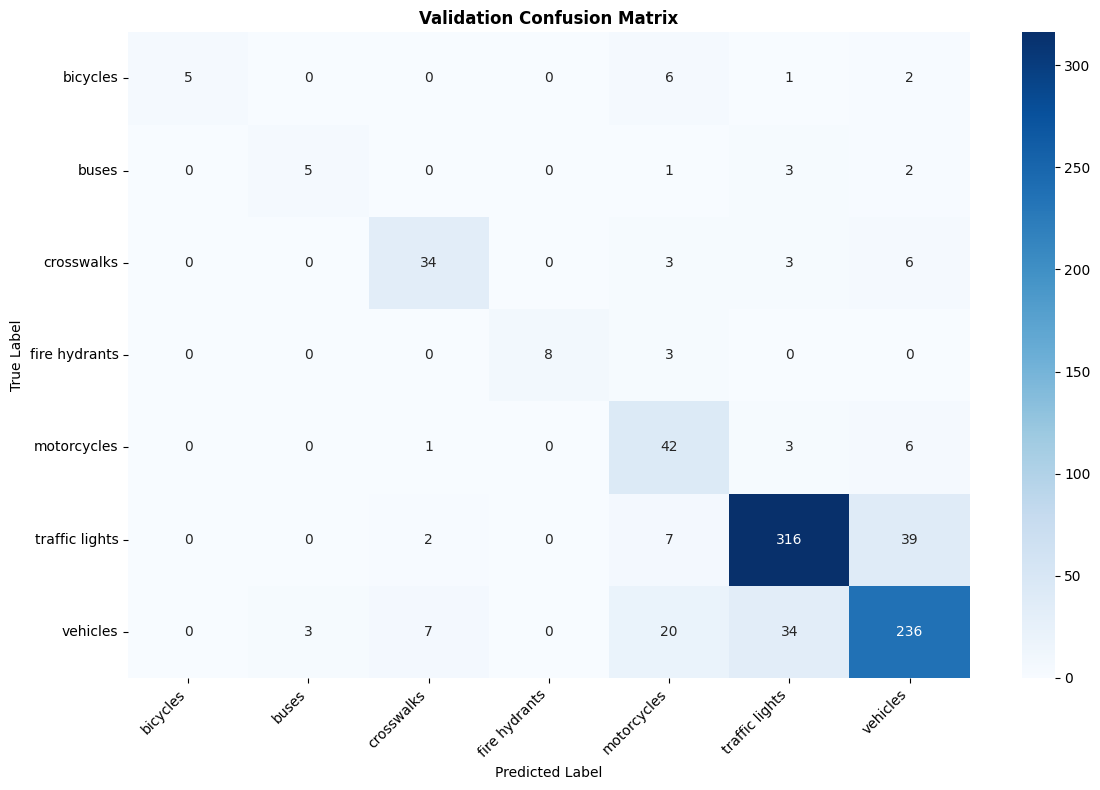


📊 Per-Class Validation Accuracy:
  bicycles: 0.3571
  buses: 0.4545
  crosswalks: 0.7391
  fire hydrants: 0.7273
  motorcycles: 0.8077
  traffic lights: 0.8681
  vehicles: 0.7867


In [ ]:
valid_classes = sorted(list(set(y_valid)))  # or use y_valid_pred for predicted classes

cm_valid = confusion_matrix(y_valid, y_valid_pred, labels=valid_classes)

print(classification_report(
    y_valid, y_valid_pred,
    target_names=valid_classes,
    zero_division=0
))

print(classification_report(
    y_valid, y_valid_pred,
    labels=class_names,
    target_names=class_names,
    zero_division=0
))

plt.figure(figsize=(12, 8))
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Validation Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=10)
plt.xlabel('Predicted Label', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_acc = cm_valid.diagonal() / cm_valid.sum(axis=1)
print("\n📊 Per-Class Validation Accuracy:")
for i, class_name in enumerate(valid_classes):
    print(f"  {class_name}: {per_class_acc[i]}")

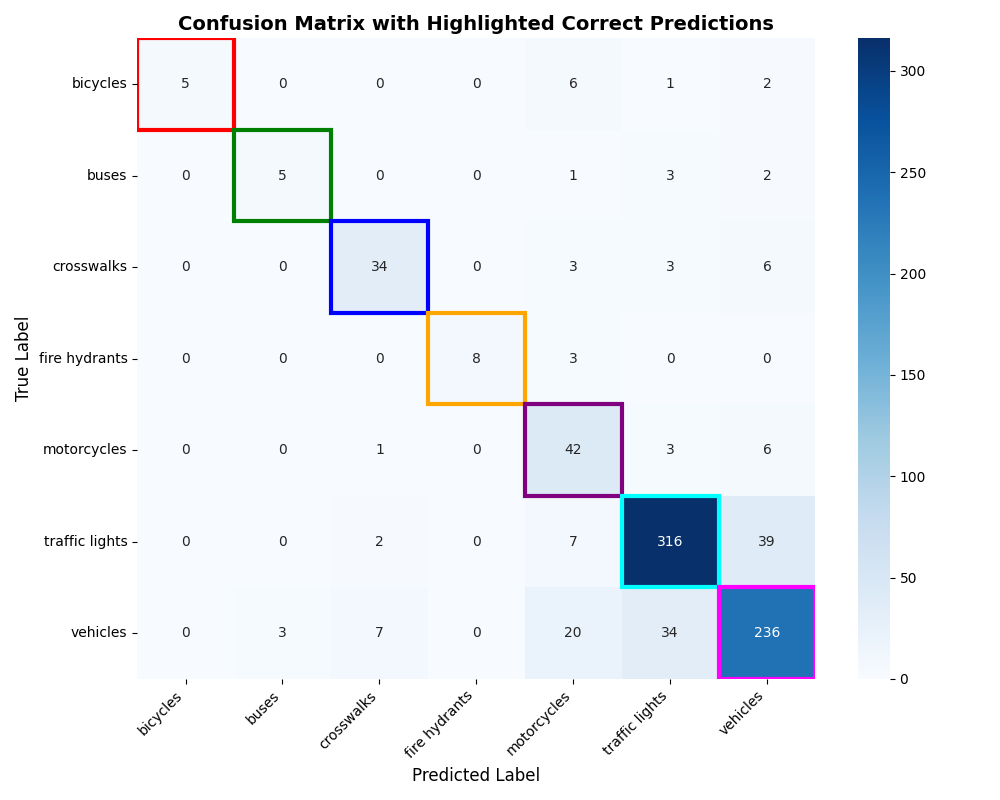

# hyperparameter tuning for your SVM model using both GridSearchCV
we could use the RandomizedSearchCV we use it for (faster for large grids)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced']
}

# Create base model
svm = SVC(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=5,                      # 5-fold cross-validation
    scoring='accuracy',        # You can also use 'f1_macro' or 'precision_macro'
    verbose=2,
    n_jobs=-1                  # Use all available cores
)

# Fit on training data
grid_search.fit(X_train_hog, y_train)

# Best parameters and score
print("\n Best Parameters:", grid_search.best_params_)
print(" Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

# update the model

# train on both the valid and train sets

drna svm best direct mn les parametert li jbnahm mn gridsearch 3lh mamchatch jsp malgre le model svm model work normal

In [ ]:


import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix



# Combine train + valid sets

X_train_final_scaled = np.vstack([X_train_scaled, X_valid_scaled])
y_train_final_encoded = np.hstack([y_train_encoded, y_valid_encoded])

print("\nCombined shapes:")
print("X_train_final:", X_train_final_scaled.shape)
print("y_train_final_encoded:", y_train_final_encoded.shape)


# Create and train SVM
svm_model = SVC(
    kernel='rbf',           # Try 'linear' or 'poly' later
    C=10,                  # Regularization strength
    gamma='scale',          # Kernel coefficient
    class_weight='balanced', # Handle imbalanced classes
    random_state=42
)

# Train (this may take a minute)
svm_model.fit(X_train_final_scaled, y_train_final_encoded)

print(f"\n the new  SVM training complete!")



Combined shapes:
X_train_final: (2529, 1764)
y_train_final_encoded: (2529,)

 the new  SVM training complete!


# evaluate on the test set

jsp ga3d ndir fl svm model normal ymchi nbdl svm best yfzd we will see

In [ ]:
# Predict on test
y_test_pred_encoded = svm_model.predict(X_test_scaled)
y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(f"\n📊 TEST Performance:")
print(f"   Accuracy:  {test_accuracy}")
print(f"   Precision: {test_precision}")
print(f"   Recall:    {test_recall}")
print(f"   F1-Score:  {test_f1}")



test_class_names = sorted(list(set(y_test)))
print(f"\n📋 Detailed Report:")
print(classification_report(y_test, y_test_pred, target_names=test_class_names, zero_division=0))





📊 TEST Performance:
   Accuracy:  0.758893280632411
   Precision: 0.7796201241933973
   Recall:    0.758893280632411
   F1-Score:  0.7534188336628247

📋 Detailed Report:
                precision    recall  f1-score   support

      bicycles       1.00      0.36      0.53        22
         buses       0.78      0.58      0.67        12
    crosswalks       0.88      0.73      0.80        81
 fire hydrants       1.00      0.39      0.56        23
   motorcycles       0.47      0.57      0.52        30
traffic lights       0.77      0.84      0.80       129
      vehicles       0.74      0.84      0.79       209

      accuracy                           0.76       506
     macro avg       0.81      0.62      0.67       506
  weighted avg       0.78      0.76      0.75       506



# confusion matrix of the test set

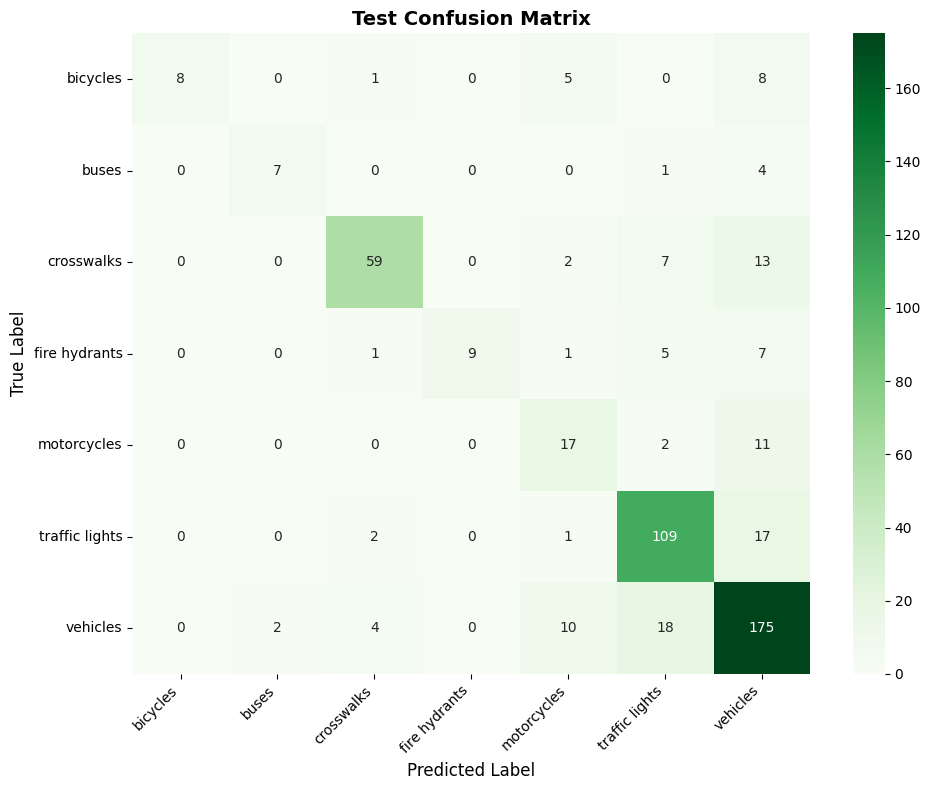


📊 Per-Class Test Accuracy:
   bicycles: 0.3636
   buses: 0.5833
   crosswalks: 0.7284
   fire hydrants: 0.3913
   motorcycles: 0.5667
   traffic lights: 0.8450
   vehicles: 0.8373


In [ ]:
# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred, labels=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_acc = cm_test.diagonal() / cm_test.sum(axis=1)
print(f"\n📊 Per-Class Test Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name}: {per_class_acc[i]:.4f}")

/tmp/ipython-input-881008891.py:33: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-881008891.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


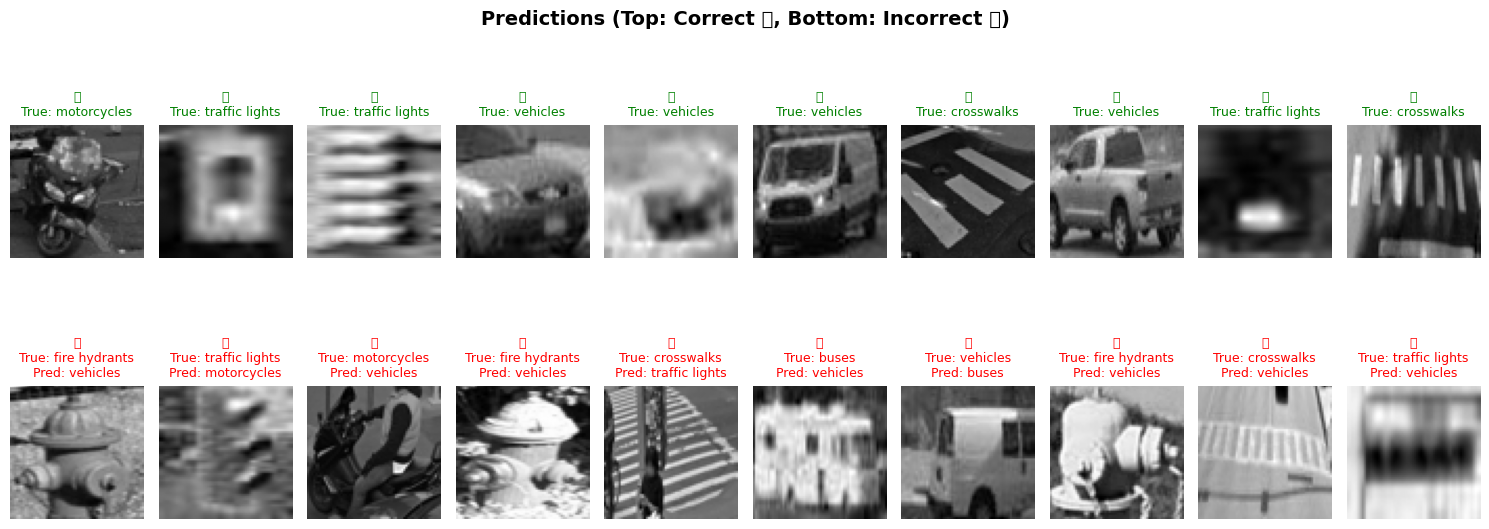


✅ Correct: 384 / 506 (75.89%)
❌ Incorrect: 122 / 506 (24.11%)


In [ ]:
# Get correct and incorrect predictions
correct_indices = np.where(y_test == y_test_pred)[0]
incorrect_indices = np.where(y_test != y_test_pred)[0]

n_samples = 20
n_correct = min(n_samples // 2, len(correct_indices))
n_incorrect = min(n_samples // 2, len(incorrect_indices))

# Sample
correct_sample = np.random.choice(correct_indices, n_correct, replace=False)
incorrect_sample = np.random.choice(incorrect_indices, n_incorrect, replace=False) if len(incorrect_indices) > 0 else []

# Plot
fig, axes = plt.subplots(2, n_samples // 2, figsize=(15, 6))

# Correct predictions
for i, idx in enumerate(correct_sample):
    axes[0, i].imshow(X_test_img[idx], cmap='gray')
    axes[0, i].set_title(f"✅\nTrue: {y_test[idx]}", fontsize=9, color='green')
    axes[0, i].axis('off')

# Incorrect predictions
for i, idx in enumerate(incorrect_sample):
    axes[1, i].imshow(X_test_img[idx], cmap='gray')
    axes[1, i].set_title(f"❌\nTrue: {y_test[idx]}\nPred: {y_test_pred[idx]}",
                         fontsize=9, color='red')
    axes[1, i].axis('off')

# Hide empty subplots
for i in range(len(incorrect_sample), n_samples // 2):
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle("Predictions (Top: Correct ✅, Bottom: Incorrect ❌)",
             y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"\n✅ Correct: {len(correct_indices)} / {len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")
print(f"❌ Incorrect: {len(incorrect_indices)} / {len(y_test)} ({len(incorrect_indices)/len(y_test)*100:.2f}%)")

In [ ]:
print("\n" + "="*60)
print("🎉 SVM PIPELINE COMPLETE!")
print("="*60)

print(f"\n📊 Final Results:")
print(f"   Validation Accuracy: {val_accuracy}")
print(f"   Test Accuracy:       {test_accuracy}")
print(f"\n   Classes: {class_names}")
print(f"   Total Training Images: {len(X_train_img)}")
print(f"   Total Test Images: {len(X_test_img)}")
print(f"   Feature Dimensions: {X_train_hog.shape[1]}")

print(f"\n💡 What's Next?")
print("   1. Try different SVM kernels: 'linear', 'poly'")
print("   2. Tune hyperparameters: C, gamma")
print("   3. Move to next model: Random Forest")


🎉 SVM PIPELINE COMPLETE!

📊 Final Results:
   Validation Accuracy: 0.8095238095238095
   Test Accuracy:       0.758893280632411

   Classes: ['bicycles', 'buses', 'crosswalks', 'fire hydrants', 'motorcycles', 'traffic lights', 'vehicles']
   Total Training Images: 1731
   Total Test Images: 506
   Feature Dimensions: 1764

💡 What's Next?
   1. Try different SVM kernels: 'linear', 'poly'
   2. Tune hyperparameters: C, gamma
   3. Move to next model: Random Forest


📊 Analyzing per-class accuracy...

  bicycles            :  36.4% (  8/ 22 correct)
  buses               :  58.3% (  7/ 12 correct)
  crosswalks          :  72.8% ( 59/ 81 correct)
  fire hydrants       :  39.1% (  9/ 23 correct)
  motorcycles         :  56.7% ( 17/ 30 correct)
  traffic lights      :  84.5% (109/129 correct)
  vehicles            :  83.7% (175/209 correct)



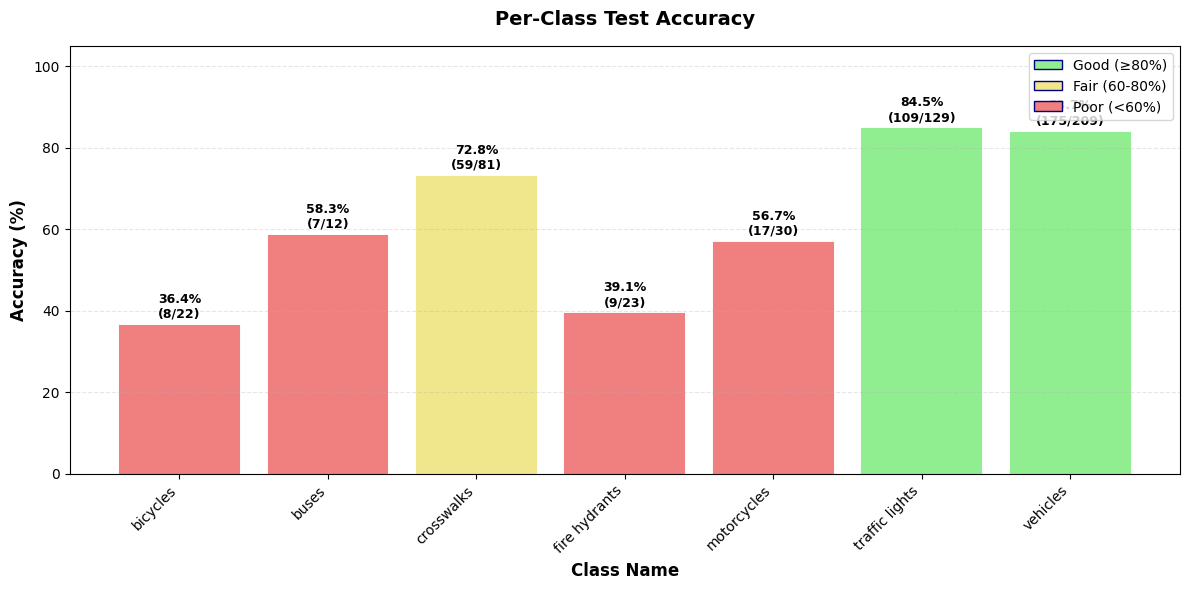


✓ Per-class analysis complete!

Insights:
  • Green bars: Classes the model handles well
  • Red bars: Classes that need attention
  • Consider collecting more data for poorly performing classes


In [ ]:
print("📊 Analyzing per-class accuracy...")
print()

# Calculate accuracy for each class
class_accuracies = {}
class_details = {}

for class_name in class_names:
    # Find all test examples of this class
    class_indices = [i for i in range(len(y_test)) if y_test[i] == class_name]

    if len(class_indices) > 0:
        # Count correct predictions
        class_correct = sum([1 for i in class_indices if y_test[i] == y_test_pred[i]])
        class_total = len(class_indices)
        class_acc = class_correct / class_total

        # Store results
        class_accuracies[class_name] = class_acc
        class_details[class_name] = (class_correct, class_total)

        # Print details
        print(f"  {class_name:20s}: {class_acc*100:5.1f}% ({class_correct:3d}/{class_total:3d} correct)")

print()

# Visualize per-class accuracy as a bar chart
plt.figure(figsize=(12, 6))

# Create bars
bars = plt.bar(
    class_accuracies.keys(),
    [acc*100 for acc in class_accuracies.values()],
    color='skyblue',
    edgecolor='navy',
    linewidth=1.5
)

# Color code bars: Green if >80%, Yellow if 60-80%, Red if <60%
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    if acc >= 0.8:
        bars[i].set_color('lightgreen')
    elif acc >= 0.6:
        bars[i].set_color('khaki')
    else:
        bars[i].set_color('lightcoral')

# Add labels
plt.xlabel('Class Name', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
plt.title('Per-Class Test Accuracy', fontsize=14, fontweight='bold', pad=15)
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, (class_name, acc) in enumerate(class_accuracies.items()):
    correct, total = class_details[class_name]
    plt.text(i, acc*100 + 2, f'{acc*100:.1f}%\n({correct}/{total})',
             ha='center', fontweight='bold', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='navy', label='Good (≥80%)'),
    Patch(facecolor='khaki', edgecolor='navy', label='Fair (60-80%)'),
    Patch(facecolor='lightcoral', edgecolor='navy', label='Poor (<60%)')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Per-class analysis complete!")
print("\nInsights:")
print("  • Green bars: Classes the model handles well")
print("  • Red bars: Classes that need attention")
print("  • Consider collecting more data for poorly performing classes")